YAMNet é um modelo de detecção acústica pré-treinado por Dan Ellis no conjunto de dados AudioSet que contém dados rotulados de mais de 2 milhões de vídeos do Youtube.

Este modelo consegue prever 521 eventos de áudio.
Recebe a forma de onda de áudio como entrada e faz previsões independentes para cada um dos 521 eventos de áudio.
Usa a arquitetura de convolução MobileNet_v1. Mais detalhes sobre toda a estrutura podem ser vistos neste artigo:
Review: MobileNetV1 — Depthwise Separable Convolution (Light Weight Model)
Esse modelo pré-treinado está disponível no Tensorflow Hub, que inclui as versões TFLite (modelo lite para dispositivos móveis) e TF.js (executando na Web).

Importando as bibliotecas

In [4]:
pip install tensorflow_hub


     ---------------------------------------- 85.4/85.4 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [6]:
import csv
import warnings
warnings.filterwarnings('ignore')
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Audio
import seaborn as sns
sns.set()
tf.__version__

'2.12.0'

Carregando o modelo que prevê 521 eventos de áudio

In [7]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

Visualizando o arquivo .csv com o mapeamento das classes do modelo

In [9]:
class_map_path = yamnet_model.class_map_path().numpy()
class_map_path

b'C:\\Users\\ppeli\\AppData\\Local\\Temp\\tfhub_modules\\9616fd04ec2360621642ef9455b84f4b668e219e\\assets\\yamnet_class_map.csv'

In [10]:
with tf.io.gfile.GFile(class_map_path) as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
    #print(row)
    print(row['display_name'])

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

In [11]:
def class_names_from_csv(class_map_csv_text):
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])
  return class_names

In [12]:
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [13]:
print(class_names)

['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble', 'Children playing', 'Animal', 'Domestic animals, pets', 'Dog', 'Bark', 'Yip', 'Howl'

In [14]:
len(class_names)

521

In [15]:
class_names[1]

'Child speech, kid speaking'

In [ ]:
Pré-processamento do arquivo de áudio

O modelo aceita um Tensor float32 1-D ou matriz NumPy contendo uma forma de onda de comprimento fixo, ou seja, devemos realizar uma normalização nas amostras de entrada, definindo o arquivo de audio como mono e com uma frequência de 16 kHz.
Para isso temos a função abaixo que faz o pré-processamento dos arquivos de áudio e também divide as formas de onda em janelas deslizantes de 0,96 segundos, saltando a cada 0,48 segundos e, em seguida, classificando cada uma destas janelas. Ver o GIF
Imagem: “MeowTalk” — How to train YAMNet audio classification model for mobile devices

Caso queira dar uma olhada nestes hiperparâmetros do modelo para normalização de cada arquivo de audio de entrada, está disponível neste link: research/audioset/yamnet/params.py

In [16]:
def preprocess_audio(audio):
  wav_file_name = audio

  wav_data, sample_rate = librosa.load(wav_file_name, sr = 16000)
  print('Taxa de amostragem: ', sample_rate)
  print('Duração: ', len(wav_data) / sample_rate)
  print('Número total de amostras: ', len(wav_data))

  scores, embeddings, spectrogram = yamnet_model(wav_data) # (N, 521) (N, 1024)
  #print(scores)
  #print()
  #print(embeddings)
  #print()
  #print(spectrogram)
  scores_np = scores.numpy()
  spectrogram_np = spectrogram.numpy()

  #print(scores_np.mean(axis=0).argmax())
  infered_class = class_names[scores_np.mean(axis=0).argmax()]
  print('O som principal é: ', infered_class)

  plt.figure(figsize=(10,6))
  plt.subplot(2,1,1)
  plt.plot(wav_data)
  plt.xlim([0, len(wav_data)])
  plt.subplot(2,1,2)
  plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest')

  mean_scores = np.mean(scores, axis=0)
  #print(mean_scores.shape)
  #print(mean_scores)
  top_n = 10
  top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
  #print(top_class_indices)
  for i in top_class_indices:
    print(class_names[i])

Taxa de amostragem:  16000
Duração:  4.0
Número total de amostras:  64000
O som principal é:  Speech
Speech
Crowd
Inside, large room or hall
Inside, public space
Outside, urban or manmade
Music
Cheering
Chatter
Run
Shout


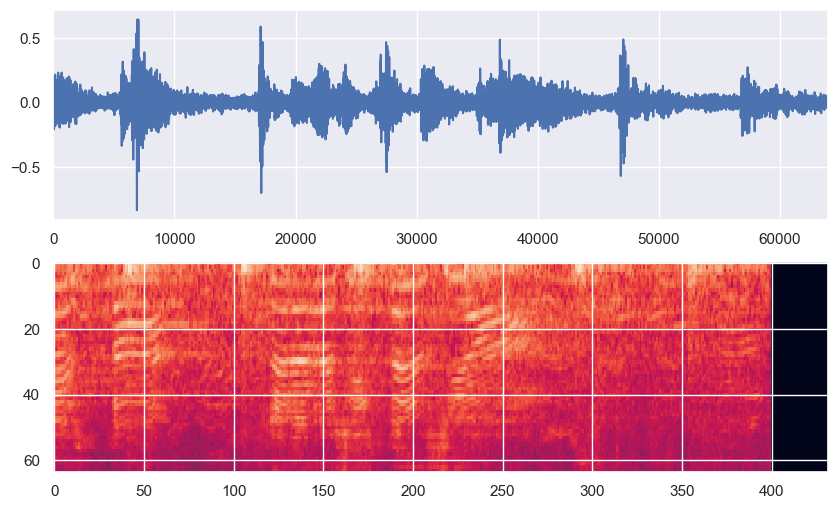

In [18]:
sample_audio = 'streetmusic.wav'
preprocess_audio(sample_audio)